In [1]:
#More or less general imports
import numpy as np, matplotlib.pyplot as plt, os
from astropy.io import fits
#from past.utils import old_div
import time
#Imports for Creating WebSky Maps 
import h5py, healpy as hp, os, sys
from pixell import enmap,utils, reproject, bunch, curvedsky, enplot
#from cosmology import *
from scipy.interpolate import *
from astropy.cosmology import Planck15 as cosmo
#Unit conversion
from astropy import units as u
from astropy.constants import k_B, h
#Creating Stamps
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.coordinates import SkyCoord
import yaml
from pixell import enmap,utils, reproject, enplot
from scipy import interpolate
import random
from astropy.nddata import block_reduce, block_replicate

#import ipyparallel as ipp
#from mpi4py import MPI

from PIL import Image
from astLib import astWCS, astImages
from scipy import ndimage
from pixell.enmap import sky2pix
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales, skycoord_to_pixel
import astropy.io.fits as pyfits
from stamping_utils import make_stamp, make_mask
import glob

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# Cosmology Constants
omegab = 0.049
omegac = 0.261
omegam = omegab + omegac
h      = 0.68
ns     = 0.965
sigma8 = 0.81
c = 3e5

H0 = 100*h
nz = 100000
z1 = 0.0
z2 = 6.0
za = np.linspace(z1,z2,nz)
dz = za[1]-za[0]

H      = lambda z: H0*np.sqrt(omegam*(1+z)**3+1-omegam)
dchidz = lambda z: c/H(z)

chia = np.cumsum(dchidz(za))*dz

zofchi = interp1d(chia,za)

In [3]:
#Access to WebSky data
path = "/scratch/jorlo/websky/"

In [4]:
#This will take a little over 2 and a half mins 
cluster_catalog=open(path + 'halos.pksc')
N = np.fromfile(cluster_catalog,count=3,dtype=np.int32)[0]
# only take first five entries for testing (there are ~8e8 halos total...)
# comment the following line to read in all halos
#N = 10
catalog=np.fromfile(cluster_catalog,count=int(N)*10,dtype=np.float32)
catalog=np.reshape(catalog,(N,10))
x  = catalog[:,0];  y = catalog[:,1];  z = catalog[:,2] # Mpc (comoving)
vx = catalog[:,3]; vy = catalog[:,4]; vz = catalog[:,5] # km/sec
R  = catalog[:,6] # Mpc

# Constants
rho      = 2.775e11*omegam*h**2 # Msun/Mpc^3
# this is M200m (mean density 200 times mean) in Msun
M        = 4*np.pi/3.*rho*R**3
chi      = np.sqrt(x**2+y**2+z**2)    # Mpc
redshift = zofchi(chi)

theta,phi = hp.vec2ang(np.column_stack((x,y,z))) # in (not with utils.degree) radians

In [5]:
ra      = phi
dec     = np.pi/2. - theta
#Limit to how bright/massive the clusters can be
#New cut at 1e14
#Less bright / massive clusters = 3.0e14
cluster_cut = 2.0e14

cluster_flags = np.where((M >= cluster_cut))[0]
#Limit on parameters of clusters
M            = M[cluster_flags]
redshift     = redshift[cluster_flags]
cluster_decs = dec[cluster_flags] * 180/np.pi
cluster_ras  = ra[cluster_flags] * 180/np.pi
r = R[cluster_flags]
#chi = chi[cluster_flags]
print(r.shape)

(246381,)


In [6]:
d_A = cosmo.angular_diameter_distance(z=redshift)
d_C = cosmo.comoving_distance(z=redshift)
d_C = d_C.value
d_A = d_A.value
theta2 = (r / d_A) * (180 * 60 / np.pi)
print(d_A)
print(theta2)

/cvmfs/soft.computecanada.ca/easybuild/software/2023/x86-64-v4/Compiler/gcccore/ipykernel/2025a/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3579: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


[ 848.37257162  515.39545626 1021.35202279 ...  963.87491317 1479.85341655
 1731.3620764 ]
[111.42438742 183.03498429  92.01153603 ...  37.90417001  24.68814516
  21.10177502]


### The Mask Map Size Issue

In [23]:
#comm = MPI.COMM_WORLD
#myrank = comm.Get_rank()
#nproc = comm.Get_size()
freqs = ["090", "150", "220"]

dr = 10*u.arcmin
offset_ra, offset_dec = np.random.rand()*5*u.arcmin, np.random.rand()*5*u.arcmin
ra_cent = cluster_ras[454]*u.deg+offset_ra
dec_cent = cluster_decs[454]*u.deg+offset_dec
ra_min, ra_max = ra_cent - dr, ra_cent + dr
dec_min, dec_max = dec_cent - dr, dec_cent + dr
box = np.array([[dec_min.value, ra_min.value],[dec_max.value, ra_max.value]]) * utils.degree
stamp, cur_wcs = make_stamp(path + '/websky_f*_map.fits', box, freqs, normalize = False)
#mask = make_mask(stamp, cluster_ras, cluster_decs, box, cur_wcs, size = 3)
#print(chi[0],theta[0])

tan:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[21.00,21.00]}


In [24]:
image=stamp
ras=cluster_ras
decs=cluster_decs
mask = np.zeros(image[0].shape)
box /= utils.degree
min_ra, max_ra, min_dec, max_dec = box[0][1], box[1][1], box[0][0], box[1][0] 

in_image = np.where((min_ra < ras) & (ras < max_ra) & (min_dec < decs) & (decs < max_dec))[0]


In [26]:
in_image

array([  454, 79196])

In [ ]:
if len(in_image) == 0:
    return mask

for i in range(len(in_image)):
    cur_cluster = in_image[i]
    cur_center = SkyCoord(ras[cur_cluster], decs[cur_cluster], unit = "deg")
    x,y = wcs.utils.skycoord_to_pixel(cur_center, cur_wcs)
    x,y = np.round(x), np.round(y)
    pix_size = wcs.utils.proj_plane_pixel_scales(cur_wcs)[0] * 60

    r = size/2/pix_size
    
    xx, yy = np.meshgrid(np.linspace(0, mask.shape[1]-1, mask.shape[1]), np.linspace(0, mask.shape[0]-1, mask.shape[0]))    
    r_mask = (xx-x)**2 + (yy-y)**2 < r**2

    mask += r_mask*(i+1)
    
    doubled_mask = mask > i+1 #Un-double counts areas where clusters overlap
    mask -= doubled_mask*(i+1)

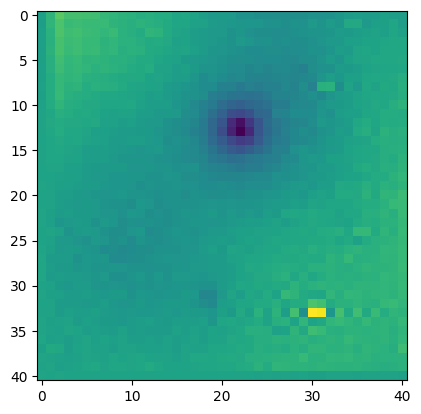

In [13]:
plt.imshow(stamp[0])

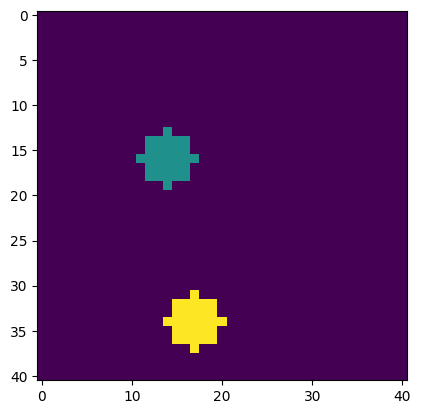

In [10]:
#lims=
plt.imshow(mask)#, vmin=-lims, vmax=lims)
#plt.savefig('mask_stamp_size')

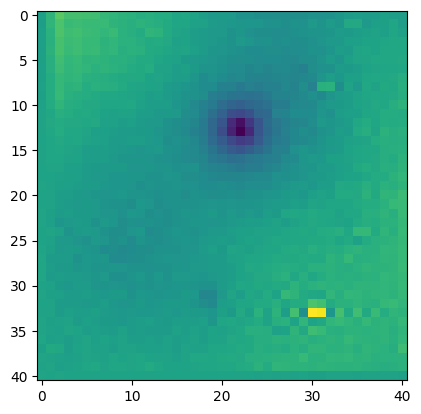

In [8]:
#lims=300
# stamp[0], stamp[1], stamp[2] are frequencies 90, 150, 220 respectively
plt.imshow(stamp[0])#, vmin=-lims, vmax=lims)
#plt.savefig('freq_stamp_size')

### Creating Stamps and Mask (All of this is for later)

For later

Creating tiles and corresponding stamps centered around celestial coordinates. In this code 313 boxes are created.

### Individual Freq Cuts

For git committing testing